In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
#import gymnasium as gym
import numpy as np
from envs.two_player_dubins_car import TwoPlayerDubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm


In [2]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

#writer = SummaryWriter('runs/cont_dubin_pg')



In [3]:

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


cpu


In [2]:
from torch.utils.tensorboard import SummaryWriter


In [3]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

In [4]:
#generate data

# Define the policy network
# def policy_network(observation):
#     net = hk.Sequential([
#         hk.Linear(128), jax.nn.relu,
#         hk.Linear(128), jax.nn.relu,
#         hk.Linear(128), jax.nn.relu,

#         hk.Linear(env.action_space.n),
#         jax.nn.softmax
#     ])
#     return net(observation)

def policy_network(observation):
    net = hk.Sequential([
        hk.Linear(32), jax.nn.relu,
        hk.Linear(env.num_actions),
        jax.nn.softmax
    ])
    return net(observation)



# def policy_network(observation, legal_moves):
#     net = hk.Sequential([
#         hk.Linear(32), jax.nn.relu,
#         hk.Linear(env.action_space.n),
#         jax.nn.softmax

#     ])
#     logits = net(observation)

#     masked_logits = jnp.multiply(logits, legal_moves)
#     probabilities = jax.nn.softmax(masked_logits)
#     return probabilities



In [5]:
# Get legal actions
def get_legal_actions_mask(state, env):
    legal_actions_mask = []
    for action in range(env.action_space.n):
        _, _, _, info = env.step(state, action, update_env=False)
        legal_actions_mask.append(int(info['is_legal']))
    return jnp.array(legal_actions_mask)


def select_action(nn_state, params, legal_actions_mask, key, epsilon):
    if jax.random.uniform(key) < epsilon:
        legal_actions_indices = jnp.arange(len(legal_actions_mask))[legal_actions_mask.astype(bool)]
        return jax.random.choice(key, legal_actions_indices)
    else:
        probs = policy_net.apply(params, nn_state, legal_actions_mask)
        return jax.random.categorical(key, probs)




In [6]:
import jax.numpy as jnp
import jax.random as jrd

rng = jrd.PRNGKey(0)
x = jrd.truncated_normal(rng, -1, 1, (100000,))
kernel = jrd.truncated_normal(rng, -1, 1, (1000, 100000))
y = jnp.matmul(kernel, x)

In [7]:
# Implement the REINFORCE algorithm

LAX_PLAYER_MAP = {0:'defender', 1:'attacker'}

def reinforce(env, num_episodes, learning_rate, gamma, batch_size, epsilon_start, epsilon_end, epsilon_decay):
    # Initialize Haiku policy network
    policy_net = hk.without_apply_rng(hk.transform(policy_network))
    initial_state = env.reset()
    initial_state_nn = env.encode_helper(initial_state)

    params = {player: policy_net.init(jax.random.PRNGKey(42), initial_state_nn) for player in env.players}
    

    # Define the optimizer
    agent_optimizer = optax.chain(
          optax.clip(1.0),
          optax.adam(learning_rate=learning_rate)
        )

    optimizer = {player: agent_optimizer for player in env.players}  
    
    opt_state = {player: optimizer[player].init(params[player]) for player in env.players}

    # Define loss function
    @jax.jit
    def loss_attacker(params, observations, actions, returns): #apply no grad to returns maybe
        action_probabilities = policy_net.apply(params, observations)
        log_probs = jnp.log(jnp.take_along_axis(action_probabilities, actions[..., None], axis=-1))
        return -jnp.mean(log_probs * jax.lax.stop_gradient(returns)) #Maybe

    @jax.jit
    def loss_defender(params, observations, actions, returns): #apply no grad to returns maybe
        action_probabilities = policy_net.apply(params, observations)
        log_probs = jnp.log(jnp.take_along_axis(action_probabilities, actions[..., None], axis=-1))
        return jnp.mean(log_probs * jax.lax.stop_gradient(returns)) #Maybe

    # Define update function
    
    @jax.jit
    def update_defender(params, opt_state, observations, actions, returns):
        grads = jax.grad(loss_defender)(params, observations, actions, returns)
        updates, opt_state = optimizer['defender'].update(grads, params=params, state=opt_state)
        return optax.apply_updates(params, updates), opt_state
    
    @jax.jit
    def update_attacker(params, opt_state, observations, actions, returns):
        grads = jax.grad(loss_attacker)(params, observations, actions, returns)
        updates, opt_state = optimizer['attacker'].update(grads, params=params, state=opt_state)
        return optax.apply_updates(params, updates), opt_state
    
    def select_action(nn_state, params, key, epsilon):
        if jax.random.uniform(key) < epsilon:
            return jax.random.choice(key, env.num_actions)
        else:
            probs = policy_net.apply(params, nn_state)
            return jax.random.categorical(key, probs)

    episode_losses = []  # Add this line to store the losses
    all_wins, all_traj_lengths = [], []
    # Train the policy network
    # Train the policy network
    batch_states = {player: [] for player in env.players}
    batch_actions = {player: [] for player in env.players}
    batch_returns = {player: [] for player in env.players}

    wins = 0
    traj_length = []

    epsilon = epsilon_start

    for episode in range(num_episodes):
        key = jax.random.PRNGKey(episode)
        valid = True
        state = env.reset()
        nn_state = env.encode_helper(state)
        
        states = {player: [] for player in env.players}
        actions = {player: [] for player in env.players}
        rewards = {player: [] for player in env.players}
        episode_length = 0
        print(f"Episode {episode} started...")
        
        
        done = False
        valid=True
        while not done and episode_length < 50:
            for player in env.players:            

                states[player].append(nn_state)
                key, subkey = jax.random.split(key)
                
                action = select_action(nn_state, params[player], subkey, epsilon)  # Use the new function here

                state, reward, done, _ = env.step(state=state, action=action, player=player, update_env=True)
                nn_state = env.encode_helper(state)
                actions[player].append(action)
                rewards[player].append(reward)
                episode_length += 1
                #print(done)
            if done: #only attacker can end the game
                wins+=1
                
            traj_length.append(episode_length)

        # if len(states) == 25:
        #     rewards[-1] = -1
                
                
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        returns = {player: [] for player in env.players}

        for player in env.players:
            G = 0
            for r in reversed(rewards['attacker']):
                if player == 'attacker':
                    G = r + gamma * G
                    returns[player].append(G)
                else:
                    G = -r + gamma * G
                    returns[player].append(G)
            
            batch_states[player].extend(states[player])
            batch_actions[player].extend(actions[player])
            batch_returns[player].extend(returns[player])

        if (episode + 1) % batch_size == 0 and valid:
            for player in env.players:
            

                # Normalize the returns for the entire batch
                # Update the policy parameters using the batch of episodes
                
                #params[player], opt_state[player] = update(params[player], opt_state[player], np.array(batch_states[player]), np.array(batch_actions[player]), np.array(batch_returns[player]), player )
                
                if player == 'defender':
                    params[player], opt_state[player] = update_defender(params[player], opt_state[player], np.array(batch_states[player]), np.array(batch_actions[player]), np.array(batch_returns[player]))
                elif player == 'attacker':
                    params[player], opt_state[player] = update_attacker(params[player], opt_state[player], np.array(batch_states[player]), np.array(batch_actions[player]), np.array(batch_returns[player]))

                
                print(f"Episode {episode} finished", 'returns:', np.mean(batch_returns[player]))
                print('num wins', wins)
                print('average_length', np.mean(traj_length))

                # writer.add_scalar('loss', np.array(loss_value), episode)
                # writer.add_scalar('num_wins', np.array(wins), episode)
                # writer.add_scalar('traj length', np.array(np.mean(traj_length)), episode)
                #writer.add_scalar('attacker_returns', np.array(np.mean(batch_returns['attacker'])), episode)

                writer.add_scalars('returns', {'defender': np.array(np.mean(batch_returns['defender'])),
                               'attacker': np.array(np.mean(batch_returns['attacker']))},
                   episode)




            all_wins.append(wins)
            all_traj_lengths.append(np.mean(traj_length))
            # Clear the batch
            batch_states = {player: [] for player in env.players}
            batch_actions = {player: [] for player in env.players}
            batch_returns = {player: [] for player in env.players}
            wins = 0
            traj_length = []
                
            
            

    return params



In [8]:
# Train the agent using REINFORCE algorithm
writer = SummaryWriter()

env = TwoPlayerDubinsCarEnv()
learning_rate = 1e-3#1e-3
gamma = 0.99
batch_size = 1
num_episodes = batch_size *5000


trained_params = reinforce(env, num_episodes=num_episodes, learning_rate=learning_rate, 
                                   gamma=gamma, batch_size=batch_size,
                                   epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.75)



#setting rewrad of 1 if goal, -1 if end of traj worked decently well

/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Episode 0 started...
Episode 0 finished returns: 1.965619026292149
num wins 0
average_length 26.0
Episode 0 finished returns: -1.965619026292149
num wins 0
average_length 26.0
Episode 1 started...
Episode 1 finished returns: -2.4862304287631343
num wins 0
average_length 26.0
Episode 1 finished returns: 2.4862304287631343
num wins 0
average_length 26.0
Episode 2 started...
Episode 2 finished returns: -2.2477607609727954
num wins 1
average_length 25.0
Episode 2 finished returns: 2.2477607609727954
num wins 1
average_length 25.0
Episode 3 started...
Episode 3 finished returns: -0.08420552289057072
num wins 0
average_length 26.0
Episode 3 finished returns: 0.08420552289057072
num wins 0
average_length 26.0
Episode 4 started...
Episode 4 finished returns: -0.0952677507470635
num wins 0
average_length 26.0
Episode 4 finished returns: 0.0952677507470635
num wins 0
average_length 26.0
Episode 5 started...
Episode 5 finished returns: -0.13927766216894352
num wins 0
average_length 26.0
Episode 5

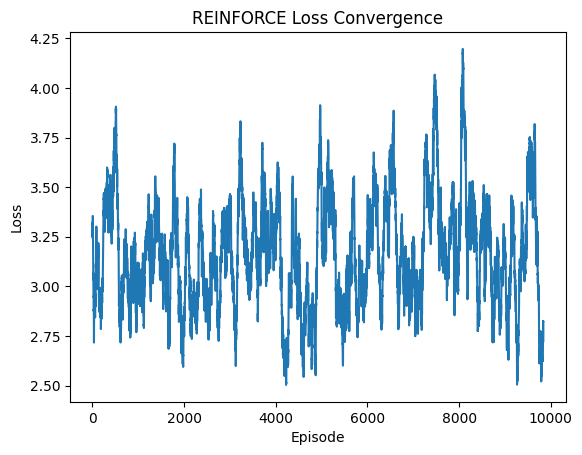

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
N = 100
l = np.convolve(losses, np.ones((N,))/N, mode='valid')


plt.plot(l)


plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('REINFORCE Loss Convergence')
plt.show()

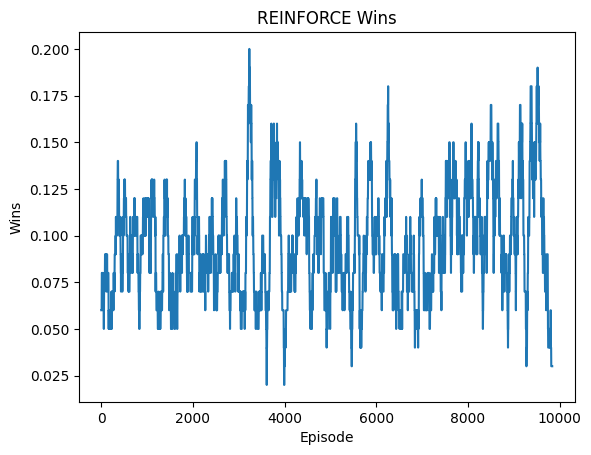

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
#plot moving average
N = 100
w = np.convolve(wins, np.ones((N,))/N, mode='valid')

plt.plot(w)
plt.xlabel('Episode')
plt.ylabel('Wins')
plt.title('REINFORCE Wins')
plt.show()

In [16]:
import imageio

def test_policy(env, params, policy_net, filename='episode.gif'):
    policy_net = hk.without_apply_rng(hk.transform(policy_network))
    key = jax.random.PRNGKey(1)

    #state = env.reset()
    state = env.set(-2., 0., 0., 3., 0., 0.)

    print(state)
    #state = env.reset()
    nn_state = env.encode_helper(state)
    frames = []
    done = False
    episode_length = 0

    while not done and episode_length < 100:
        for player in env.players:
        
            key, subkey = jax.random.split(key)
            probs = policy_net.apply(params[player], nn_state)
            
            #action = jax.random.choice(subkey, jnp.arange(4))
            action = np.argmax(probs)
            print(action)
            #print(reweighted_probs)
            state, _, done, info = env.step(state=state, action=action, player=player, update_env=True)
            nn_state = env.encode_helper(state)
            episode_length += 1
            env.render()
            print(info)

    env.make_gif("two_player_animation_nash_pg.gif")
    

# Example usage
#trained_params, _ = reinforce(env, num_episodes, learning_rate, gamma)
env = TwoPlayerDubinsCarEnv()

test_policy(env, trained_params, policy_network)


/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


{'attacker': array([-2.,  0.,  0.], dtype=float32), 'defender': array([3., 0., 0.], dtype=float32)}
2
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
3
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
3
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
1
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
3
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
1
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
3
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
1
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
3
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
1
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
3
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
1
{'player': 'attacker', 'is_legal': True, 'status': 'in_progress'}
3
{'player': 'defender', 'is_legal': True, 'status': 'in_progress'}
1
{'player': 'at

In [95]:
def plot_surface(X_in,env, file_name=None, y_pred=None, ys=None):
    %matplotlib inline

    plt.rcParams['figure.figsize'] = [15, 12]

    # Plot...
    plt.scatter(X_in[:,0], X_in[:,1], s=1) # s is a size of marker 
    plt.colorbar(label='estimated value')
    goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

    # draw obstacle
    obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
    plt.gca().add_artist(obstacle)
    plt.gca().add_artist(goal)


    arrow_len = env.v_max
    # Calculate arrow components
    arrow_dx = arrow_len * np.cos(X_in[:,2])
    arrow_dy = arrow_len * np.sin(X_in[:,2])

    if y_pred:
        arrow_colors = cm.jet((y_pred-np.min(y_pred))/(np.max(y_pred)-np.min(y_pred)))
    elif len(ys)>0:
        arrow_colors = cm.get_cmap('jet', 3)(ys+1)

    else:
        arrow_colors = 'k'


    plt.quiver(X_in[:,0], X_in[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


    #plt.jet()
    #plt.show()
    if file_name:
        plt.savefig(file_name)
    #plt.show()


In [ ]:
#generate data

x_s = np.linspace(-4,4, 25)
y_s = np.linspace(-4,4, 25)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)

9375

In [ ]:
X_grid_encoded = [env.encode_helper(x) for x in X_grid]

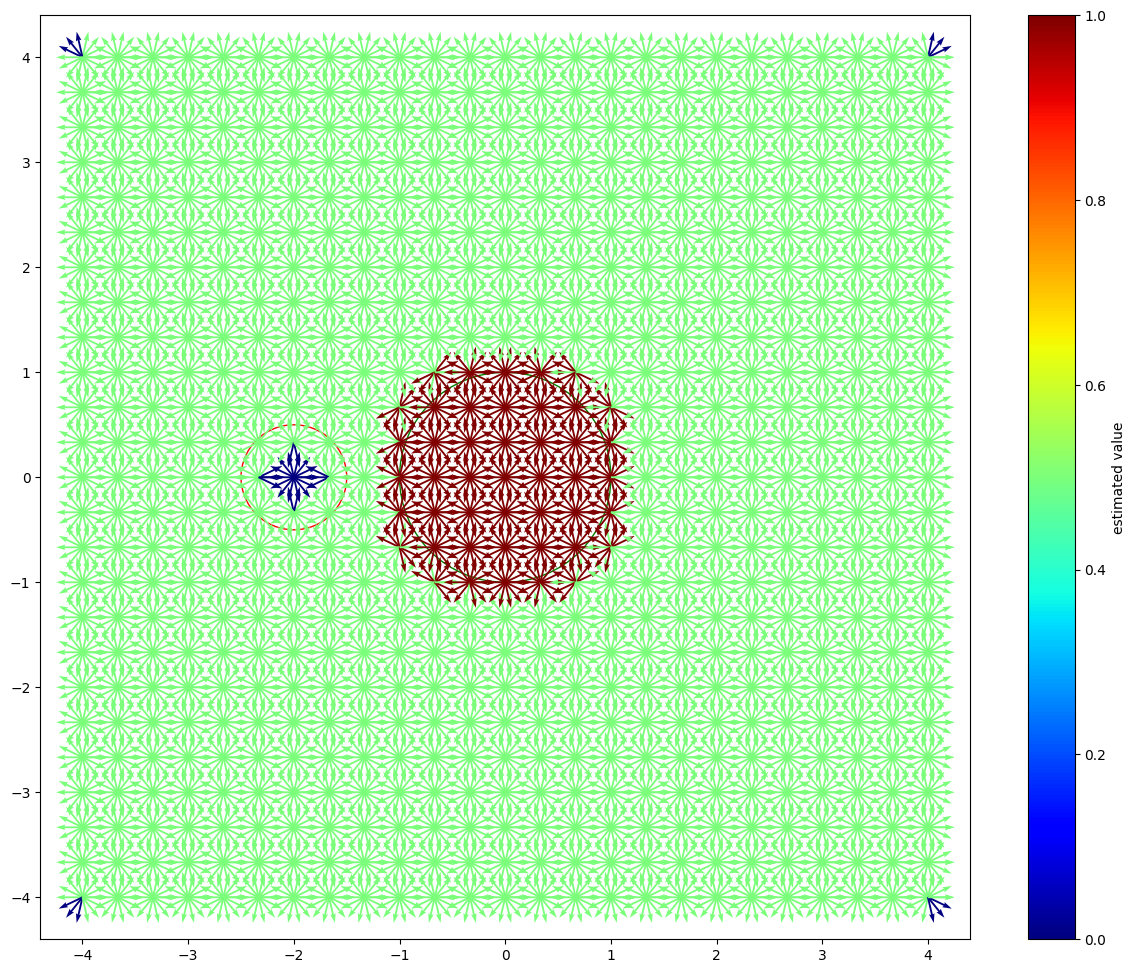

In [ ]:
values = []

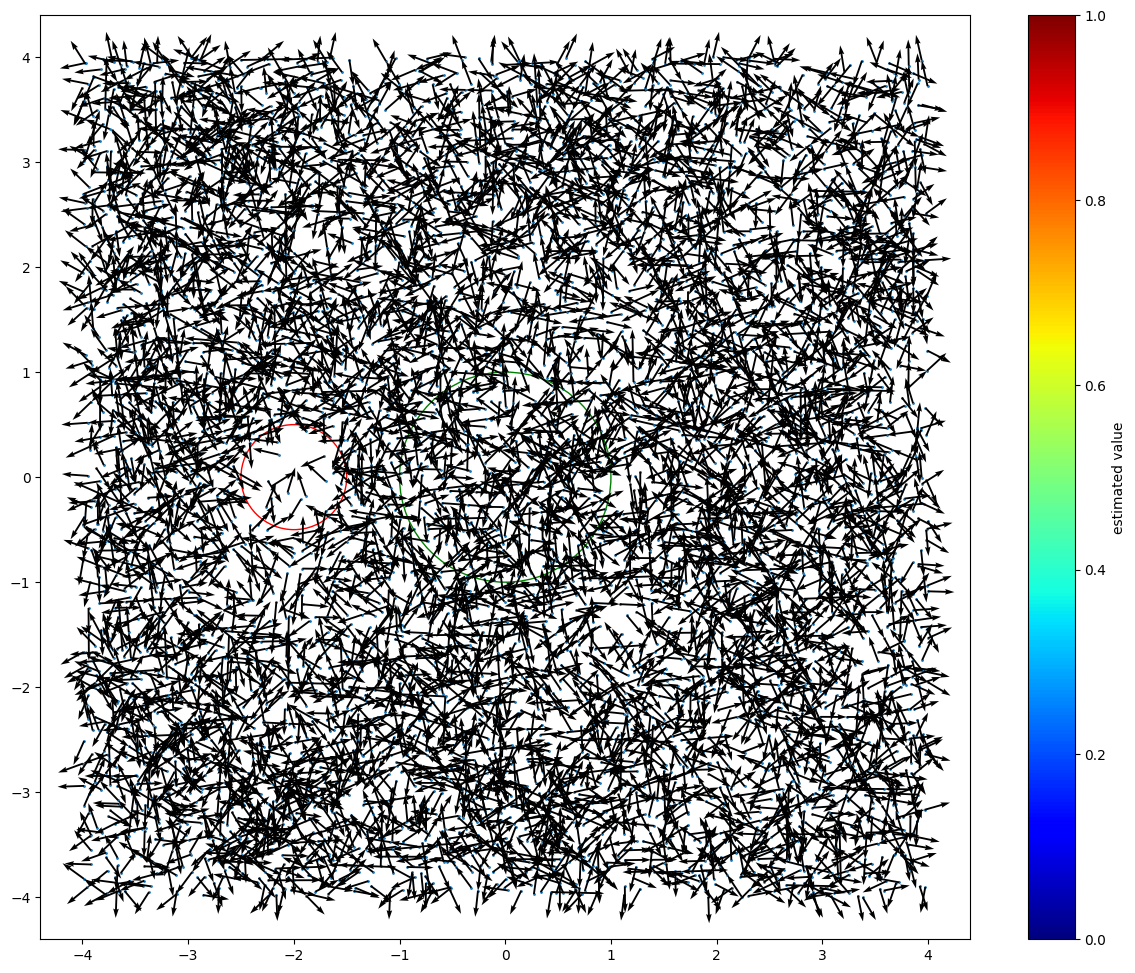

In [ ]:


plot_surface(X_val, env, ys=[])

In [ ]:
x_mean = np.mean(X_grid[:, 0])
x_std = np.std(X_grid[:, 0])
y_mean = np.mean(X_grid[:, 1])
y_std = np.std(X_grid[:, 1])


def normalize(X):
    X[:, 0] = (X[:, 0] - x_mean) / x_std
    X[:, 1] = (X[:, 1] - y_mean) / y_std
    return X

#X = normalize(X)

In [ ]:
X3 = X.copy()
X_val3 = X_val.copy()
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X_val = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))




In [ ]:
X

array([[-4.00000000e+00, -4.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-4.00000000e+00, -4.00000000e+00,  9.00968868e-01,
         4.33883739e-01],
       [-4.00000000e+00, -4.00000000e+00,  6.23489802e-01,
         7.81831482e-01],
       ...,
       [ 4.00000000e+00,  4.00000000e+00,  6.23489802e-01,
        -7.81831482e-01],
       [ 4.00000000e+00,  4.00000000e+00,  9.00968868e-01,
        -4.33883739e-01],
       [ 4.00000000e+00,  4.00000000e+00,  1.00000000e+00,
        -2.44929360e-16]])

In [ ]:

def forward(X):
    l1 = hk.Linear(128)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(128)(l2)
    l4 = jax.nn.relu(l3)
    l5 = hk.Linear(128)(l4)
    l6 = jax.nn.relu(l5)

    l7= hk.Linear(1)(l6)

    return l7

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

# @jax.jit
# def loss_fn(params, X, y):
#     err = forward(params, X) - y
#     return jnp.mean(jnp.square(err))  # mse


l2_reg_strength = 1e-4  # Adjust this to control the strength of regularization

def l2_regularization(params):
    l2_loss = 0.0
    for param in jax.tree_leaves(params):
        if param.ndim > 1:
            l2_loss += jnp.sum(jnp.square(param))
    return l2_loss

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    mse_loss = jnp.mean(jnp.square(err))
    l2_loss = l2_reg_strength * l2_regularization(params)
    return mse_loss + l2_loss



optimizer = optax.adamw(learning_rate=10e-5)
batch_size = 100 #make it 200
losses = [np.inf]
val_losses = [np.inf]
#check we aren't double using gradients
opt_state = optimizer.init(params)
gamma = 0.8

@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    #updates, opt_state = optimizer.update(grads, opt_state)
    updates, opt_state = optimizer.update(grads,params=params, state= opt_state)

    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

FIRST = True

for epoch in range(100):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]


        if FIRST:
            y_batch = ys[batch:batch+batch_size]
            #print(np.unique(y_batch, return_counts=True))
        else:
            y_batch = env.sample_value_iter(X_batch, forward, params, gamma=gamma)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    FIRST = False
    epoch_loss /= (len(X) // batch_size)

    # y_val = env.sample_value_iter(X_val, forward, params, gamma=gamma)

    # val_loss = loss_fn(params, X_val, y_val)
    # print("val_loss", val_loss, 'delta' , np.abs(val_loss - val_losses[-1]))
    # if val_losses[-1] - val_loss < 0.0001:
    #     print("early stopping",val_losses[-1] - val_loss)
    #     break
    # val_losses.append(val_loss)


    print('epoch', epoch, 'average loss', epoch_loss, 'epoch delta', np.abs(epoch_loss - losses[-1]))
    losses.append(epoch_loss)

#todo impolement val set for early stopping


/tmp/ipykernel_3654102/3303103726.py:35: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  for param in jax.tree_leaves(params):


epoch 0 average loss 0.11854396 epoch delta inf
epoch 1 average loss 0.083749644 epoch delta 0.034794316
epoch 2 average loss 0.081574656 epoch delta 0.0021749884
epoch 3 average loss 0.07373762 epoch delta 0.007837035
epoch 4 average loss 0.069426246 epoch delta 0.0043113753
epoch 5 average loss 0.06495849 epoch delta 0.0044677556
epoch 6 average loss 0.061741874 epoch delta 0.0032166168
epoch 7 average loss 0.058662813 epoch delta 0.0030790605
epoch 8 average loss 0.056213867 epoch delta 0.0024489462
epoch 9 average loss 0.054252163 epoch delta 0.0019617043
epoch 10 average loss 0.052777983 epoch delta 0.0014741793
epoch 11 average loss 0.05168168 epoch delta 0.0010963045
epoch 12 average loss 0.05084209 epoch delta 0.0008395873
epoch 13 average loss 0.050059196 epoch delta 0.00078289583
epoch 14 average loss 0.04936461 epoch delta 0.0006945841
epoch 15 average loss 0.04874571 epoch delta 0.0006189011
epoch 16 average loss 0.048241824 epoch delta 0.0005038865
epoch 17 average loss 0.

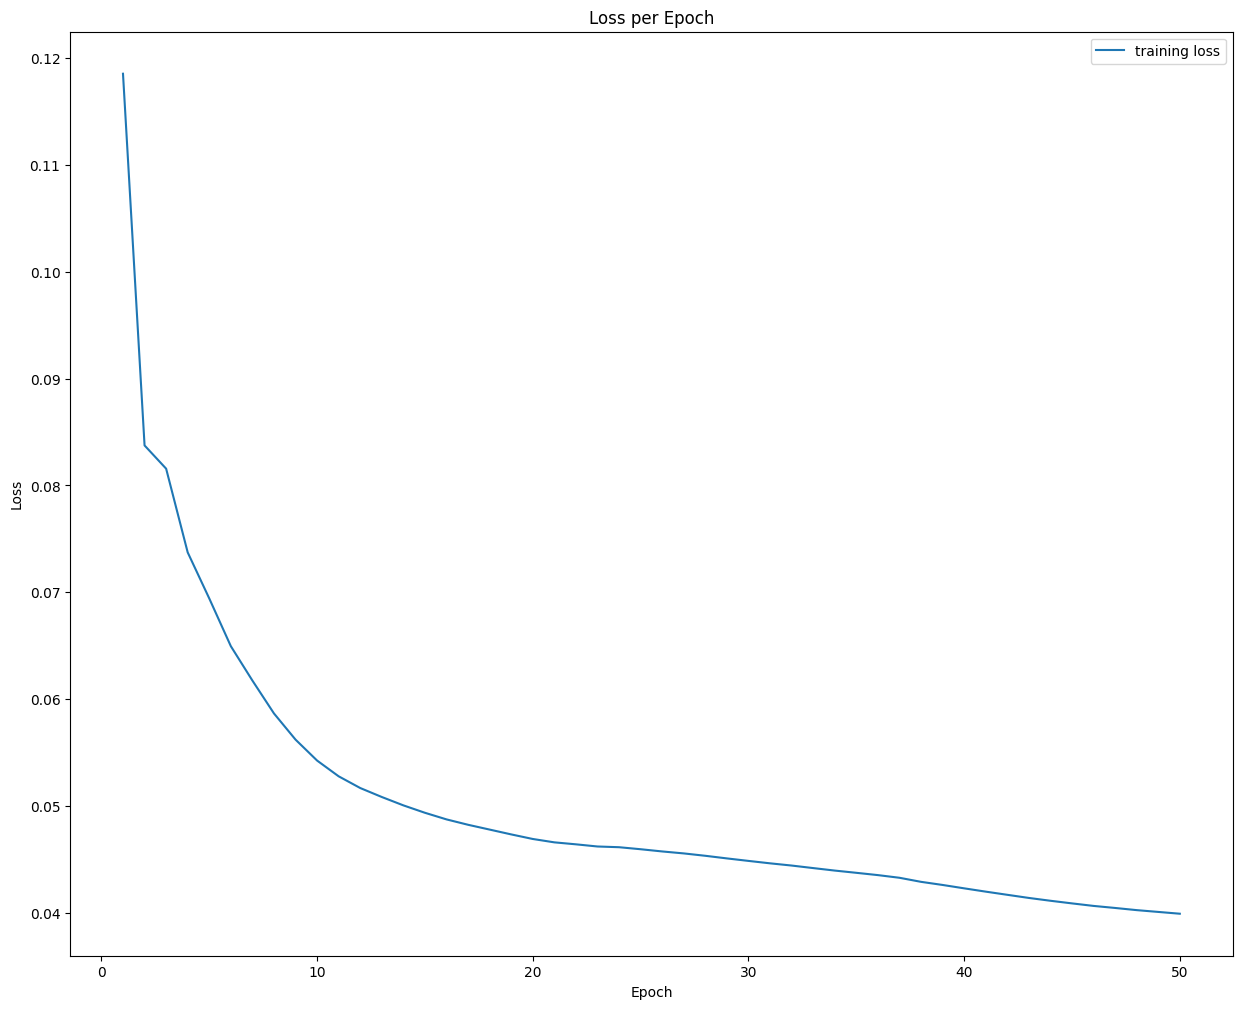

In [ ]:
# Plot the losses
%matplotlib inline

lo = [l for l in losses]
#vlo = [l for l in val_losses]


plt.plot(lo, label='training loss')
#plt.plot(vlo, label='validation loss')

# Add a title and labels to the x and y axis
plt.legend()
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

NameError: name 'policy_net' is not defined

In [ ]:



y_pred = [forward(X=x, params=params) for x in X_test_encoded]

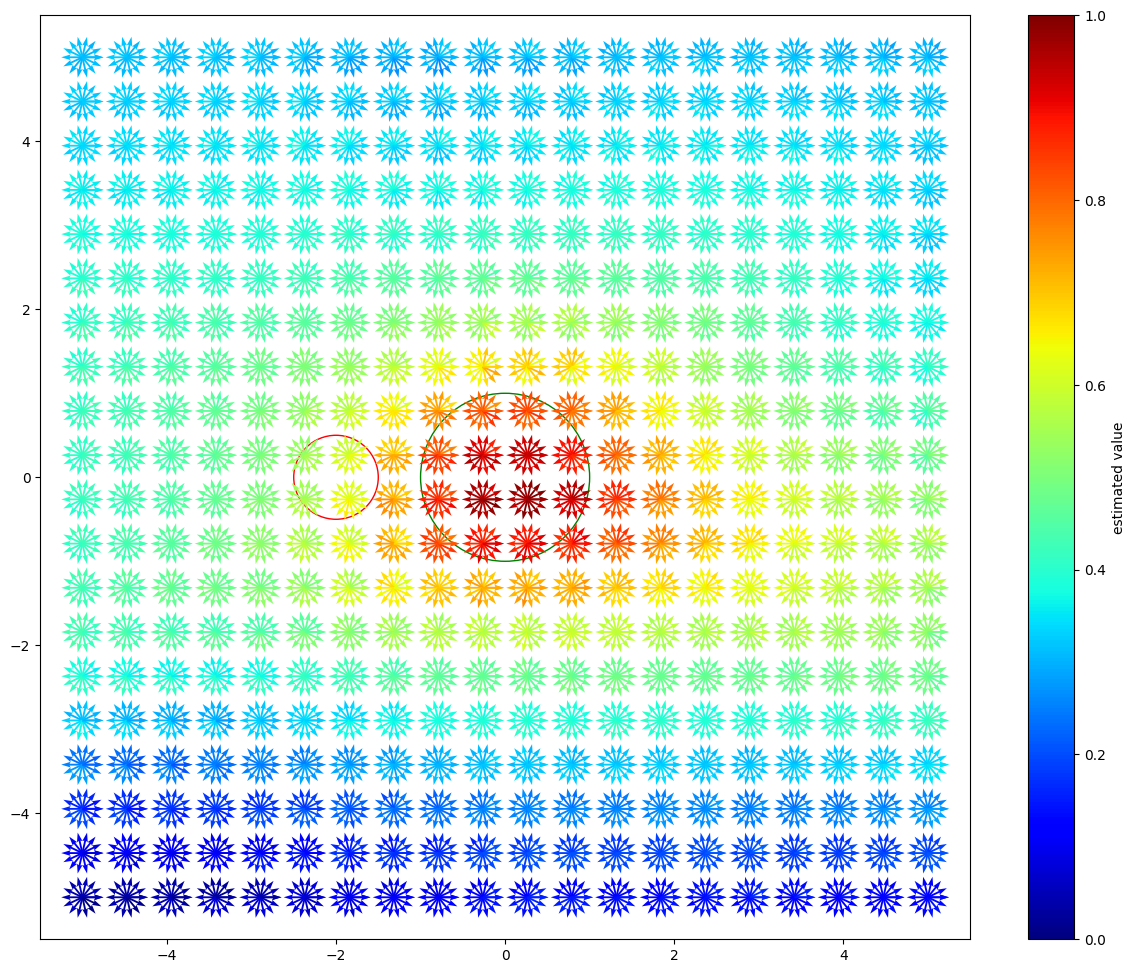

In [ ]:
plot_surface(X_test, env, 'experiment.png', y_pred)

In [ ]:
y_train = [forward(X=x, params=params) for x in X]

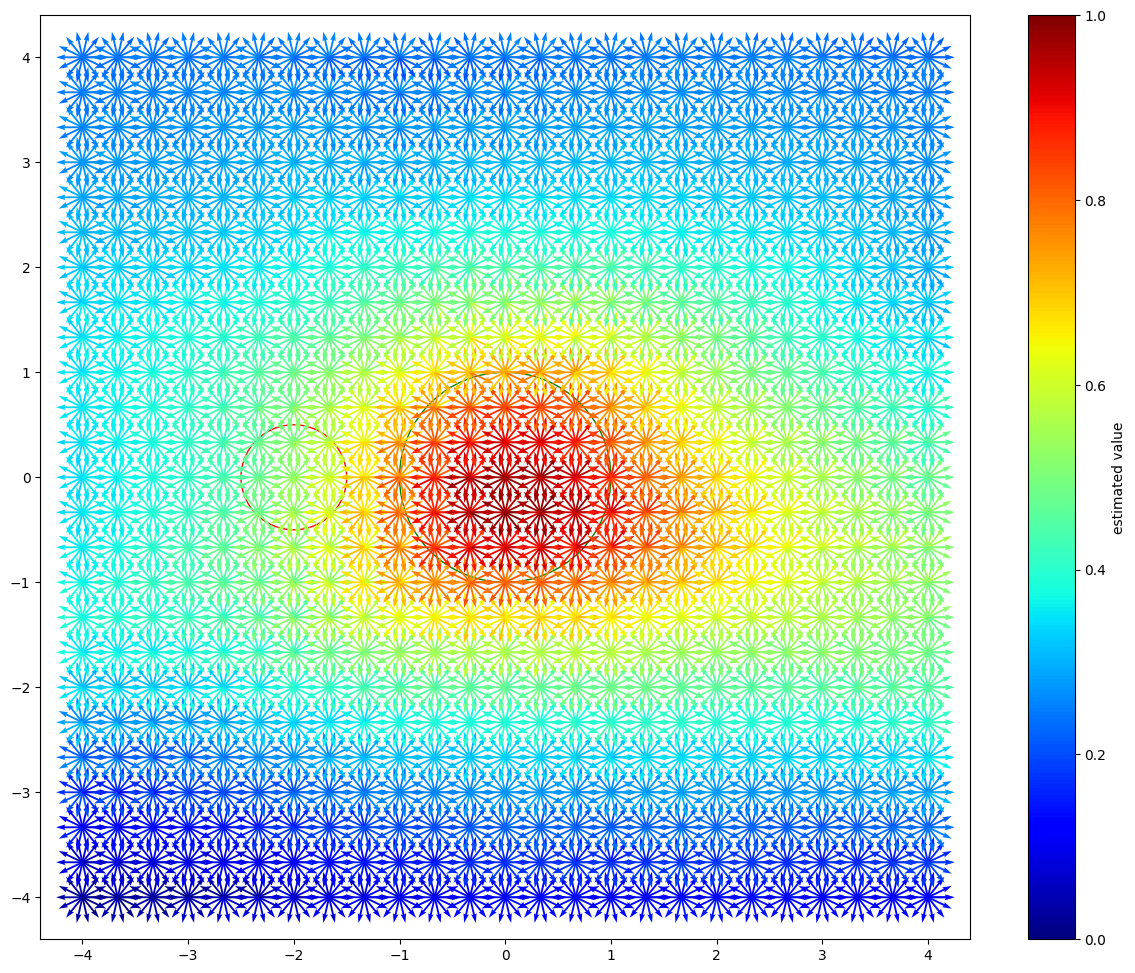

In [ ]:
plot_surface(X3, env, 'experiment.png', y_train)

In [ ]:
#train on small steps, run on bigger steps?
right = 0.0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(-3.9,-3.9, up)
#state = env.reset()

gamma = gamma
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, info = env.step(state, a, update_env=False)


        if info['is_legal']:
            estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)
            value = reward + gamma*estimate[0]
            possible_actions.append(value)
        else:
            possible_actions.append(-np.inf)

    print(possible_actions)
    action = np.argmax(np.array(possible_actions))
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
    
env.make_gif()

[Array(-0.19741069, dtype=float32), Array(-0.16031922, dtype=float32), -inf]
1
[Array(-0.1623875, dtype=float32), Array(-0.1288733, dtype=float32), -inf]
2
[Array(-0.14629662, dtype=float32), Array(-0.09280137, dtype=float32), -inf]
3
[Array(-0.12062545, dtype=float32), Array(-0.06140415, dtype=float32), -inf]
4
[Array(-0.08132228, dtype=float32), Array(-0.02635226, dtype=float32), -inf]
5
[Array(-0.0322419, dtype=float32), Array(0.0098683, dtype=float32), -inf]
6
[Array(0.01006032, dtype=float32), Array(0.0460726, dtype=float32), -inf]
7
[Array(0.04699951, dtype=float32), Array(0.08160431, dtype=float32), -inf]
8
[Array(0.08481767, dtype=float32), Array(0.11419471, dtype=float32), -inf]
9
[Array(0.11284085, dtype=float32), Array(0.1426463, dtype=float32), -inf]
10
[Array(0.13049252, dtype=float32), Array(0.15197735, dtype=float32), -inf]
11
[Array(0.1406344, dtype=float32), Array(0.13802901, dtype=float32), -inf]
12
[Array(0.14495775, dtype=float32), Array(0.15629461, dtype=float32), 

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

ValueError: 'linear/w' with retrieved shape (4, 12) does not match shape=[3, 12] dtype=dtype('float32')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [ ]:
forward(X=np.array([-4,-4,1, 1]), params=params) 

Array([1.237214], dtype=float32)

In [ ]:
forward(X=np.array([0,0,1, 0]), params=params) 

Array([0.08173393], dtype=float32)

In [ ]:
env.step(np.array([0,0,np.pi]), 0, update_env=False)

(array([2.50000000e-01, 4.37113883e-08, 2.00712864e+00]), 100, True, {})

In [ ]:
X[0]

array([ 1.8830727 , -1.7482759 ,  0.23815954, -0.97122604], dtype=float32)

In [ ]:
try 90 degree turns first, try dropout or batch norm, standaridse all states, if relu add non trainable params 